## Librerías:

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from torchvision.models import resnet50, resnet101, resnet152, ResNet50_Weights,ResNet101_Weights, ResNet152_Weights
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Visualizar una matriz de confusión para una etiqueta específica
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from SupportFunc.Loader import MultiLabelImageDataset
from SupportFunc.AdaptiveAttention import AdaptiveAttention, AdaptiveTransformerEncoderLayer
from SupportFunc.Visualization import plot_confusion_matrix, plot_train_val_curve

## Parámetros y funciones:

In [2]:
class AdaptiveAttentionClassifier(nn.Module):
    def __init__(self, image_feature_dim, num_classes):
        super(AdaptiveAttentionClassifier, self).__init__()
        self.image_embed = nn.Linear(image_feature_dim, 512)
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Proyección de características
        image_embeddings = self.image_embed(image_features)

        # Pasar por las capas del Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings.unsqueeze(1)).squeeze(1)

        # Clasificador final
        output = self.mlp(image_embeddings)
        return output


In [ ]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 1
batch_size = 32
lr = 0.0001
image_feature_dim = 2048

subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

302


## Carga de datos:

### Selección de subset para pruebas:

In [ ]:
# Leer y filtrar datos
train_1 = pd.read_csv(f'{data_directory}/train_data.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data.csv')

train_1 = train_1[train_1['ID'].isin(subset)]
test_1 = test_1[test_1['ID'].isin(subset)]

# Guardar los archivos filtrados
train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding = 'utf-8', index=False)
train_1.to_csv(f'{data_directory}/test_data_2.csv', encoding = 'utf-8', index=False)

# Crear datasets y DataLoaders
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Instanciar modelo:

In [ ]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet = models.resnet101(weights=ResNet101_Weights.DEFAULT)  # Para ResNet101
#resnet = models.resnet152(weights=ResNet152_Weights.DEFAULT)  # Para ResNet152

# Congelar todas las capas inicialmente
for param in resnet.parameters():
    param.requires_grad = False

# Descongelar las capas que quieres ajustar (por ejemplo, 'layer4' o 'fc')
for param in resnet.layer4.parameters():  # Afinar el bloque final
    param.requires_grad = True
    
# Reemplazar la capa final con una capa adaptada a tu número de clases
num_classes = train_dataset[0][1].size(0)  # Obtener el número de clases desde el dataset
resnet.fc = nn.Identity()
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

model = AdaptiveAttentionClassifier(image_feature_dim=image_feature_dim, num_classes=num_classes)
model = model.to(device)

# Optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)

In [7]:
#Comprobar que las dimensiones de salida de resnet sean consistentes con la siguiente capa
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
image_features = resnet(images)
print(image_features.shape)

torch.Size([16, 2048])


## Entrenamiento:

In [ ]:
# Entrenamiento
train_losses = list()
val_losses = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = resnet(images).flatten(start_dim=1)
            outputs = model(image_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Imprimir métricas
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 0.6803, Val Loss: 0.6090
Epoch 2/10, Train Loss: 0.5895, Val Loss: 0.5320
Epoch 3/10, Train Loss: 0.5343, Val Loss: 0.4880
Epoch 4/10, Train Loss: 0.5024, Val Loss: 0.4586
Epoch 5/10, Train Loss: 0.4792, Val Loss: 0.4385
Epoch 6/10, Train Loss: 0.4644, Val Loss: 0.4239
Epoch 7/10, Train Loss: 0.4543, Val Loss: 0.4119
Epoch 8/10, Train Loss: 0.4449, Val Loss: 0.4019
Epoch 9/10, Train Loss: 0.4380, Val Loss: 0.3943
Epoch 10/10, Train Loss: 0.4324, Val Loss: 0.3884


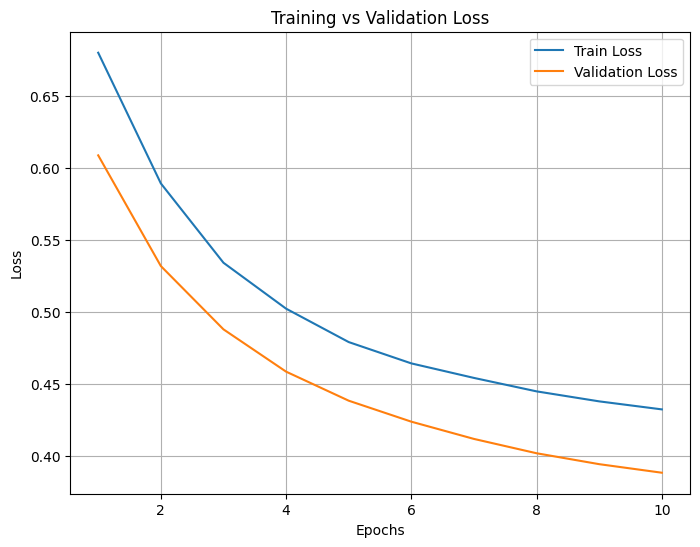

In [9]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

## Inferencia y métricas:

In [10]:
# Coloca el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = list()
all_preds = list()

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Extraer características con ResNet y pasar por el modelo
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

In [11]:
# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       0.97      0.54      0.69        65
      NORMAL       0.00      0.00      0.00        33
          MH       0.00      0.00      0.00        27
         ODC       0.00      0.00      0.00        25
        TSLN       1.00      0.04      0.08        23
        ARMD       1.00      0.09      0.17        11
          DN       0.00      0.00      0.00        25
         MYA       0.00      0.00      0.00        14
        BRVO       0.00      0.00      0.00        12
         ODP       0.00      0.00      0.00         5
        CRVO       0.00      0.00      0.00         2
         CNV       0.00      0.00      0.00         0
          RS       0.00      0.00      0.00         4
         ODE       0.50      0.25      0.33         4
          LS       0.00      0.00      0.00        10
         CSR       0.00      0.00      0.00         5
         HTR       0.00      0.00      0

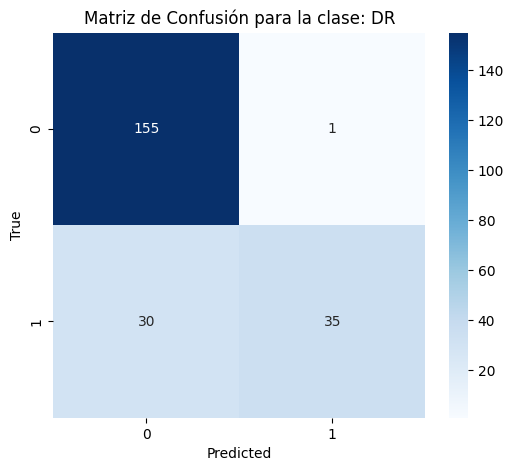

In [12]:
# Ejemplo: Visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]
plot_confusion_matrix(confusion_matrices[0], class_name)

---

Epoch 1/10, Train Loss: 0.4298, Val Loss: 0.3928
Epoch 2/10, Train Loss: 0.4234, Val Loss: 0.3867
Epoch 3/10, Train Loss: 0.4199, Val Loss: 0.3817
Epoch 4/10, Train Loss: 0.4149, Val Loss: 0.3775
Epoch 5/10, Train Loss: 0.4126, Val Loss: 0.3739
Epoch 6/10, Train Loss: 0.4081, Val Loss: 0.3710
Epoch 7/10, Train Loss: 0.4063, Val Loss: 0.3683
Epoch 8/10, Train Loss: 0.4030, Val Loss: 0.3658
Epoch 9/10, Train Loss: 0.4015, Val Loss: 0.3636
Epoch 10/10, Train Loss: 0.3986, Val Loss: 0.3616


In [ ]:
# Entrenamiento

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = resnet(images).flatten(start_dim=1)
            outputs = model(image_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Imprimir métricas
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 0.6978, Val Loss: 0.6690
Epoch 2/10, Train Loss: 0.6636, Val Loss: 0.6318
Epoch 3/10, Train Loss: 0.6290, Val Loss: 0.5990
Epoch 4/10, Train Loss: 0.6028, Val Loss: 0.5712
Epoch 5/10, Train Loss: 0.5765, Val Loss: 0.5482
Epoch 6/10, Train Loss: 0.5606, Val Loss: 0.5297
Epoch 7/10, Train Loss: 0.5449, Val Loss: 0.5147
Epoch 8/10, Train Loss: 0.5312, Val Loss: 0.5021
Epoch 9/10, Train Loss: 0.5220, Val Loss: 0.4913
Epoch 10/10, Train Loss: 0.5128, Val Loss: 0.4818


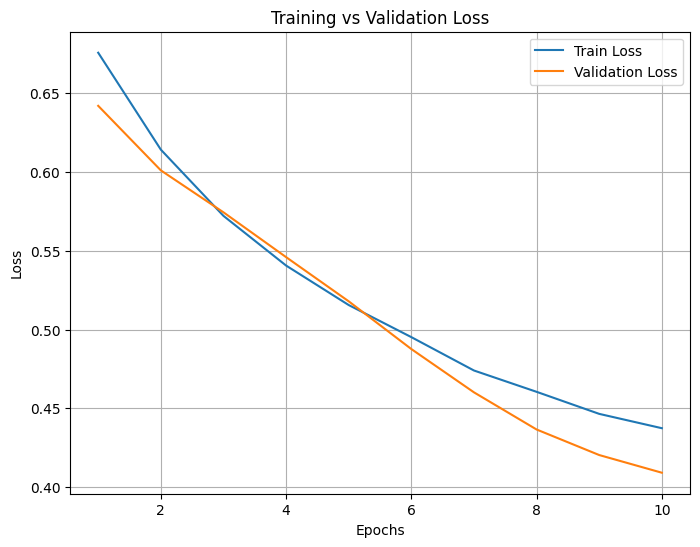

In [ ]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

In [ ]:
# Coloca el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = list()
all_preds = list()

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Extraer características con ResNet y pasar por el modelo
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

In [ ]:
# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       1.00      0.21      0.35        43
      NORMAL       0.00      0.00      0.00        23
          MH       0.00      0.00      0.00        14
         ODC       0.00      0.00      0.00        19
        TSLN       1.00      0.10      0.18        10
        ARMD       0.00      0.00      0.00         5
          DN       0.00      0.00      0.00        15
         MYA       0.00      0.00      0.00         9
        BRVO       1.00      0.20      0.33         5
         ODP       0.00      0.00      0.00         2
        CRVO       0.00      0.00      0.00         2
         CNV       0.00      0.00      0.00         0
          RS       0.00      0.00      0.00         0
         ODE       0.00      0.00      0.00         2
          LS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00         5
         HTR       0.00      0.00      0

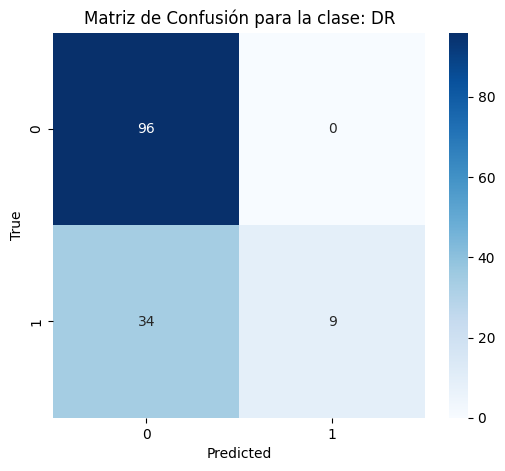

In [ ]:
# Ejemplo: Visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]
plot_confusion_matrix(confusion_matrices[0], class_name)